In [9]:
## Libraries
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
from insight.pv_model import pv_model_class
import cvxpy as cp
import pandas as pd
import os

In [10]:
# Constants and variables

Iscn = 8.21 # nominal short circuit current
Vocn = 32.9 # nominal open circuit voltage
Imp = 7.61 # array current at MPP
Vmp = 26.3 # array voltage at MPP
Pmax_e = Vmp * Imp # experimental array max power output
Kv = -0.123 # voltage temperature coefficient
Ki = 0.0032 # current temperature coefficient
Ns = 54 # number of series cells
Gn = 1000. # nominal irradiance
G = Gn
Tn = 25. + 273.15 # nominal operating temperature
T = Tn

Egap = 1.8 * 10 ** -19 # Bandgap of silicon (silicio cristalino)

err = 0.0001
inverter_eff = 0.95
array_dim = [1, 1]

In [11]:
### Linear Program Example -- CVXPY

m = 15
n = 10
np.random.seed(1)
s0 = np.random.randn(m)
lamb0 = np.maximum(-s0, 0)
s0 = np.maximum(s0, 0)
x0 = np.random.randn(n)
A = np.random.randn(m, n)
b = A @ x0 + s0
c = -A.T @ lamb0

# Define and solve the CVXPY problem.
x = cp.Variable(n)
prob = cp.Problem(cp.Minimize(c.T@x),
                 [A @ x <= b])
prob.solve()

# Print result.
print("\nThe optimal value is", prob.value)
print("A solution x is")
print(x.value)
print("A dual solution is")
print(prob.constraints[0].dual_value)


## use '@' when doing multiplication between vectors and matrices -- turns them into scalars
## use '*' when doing multiplication between scalars and vectors or matrices


The optimal value is -15.220912605552861
A solution x is
[-1.10133381 -0.16360111 -0.89734939  0.03216603  0.6069123  -1.12687348
  1.12967856  0.88176638  0.49075229  0.8984822 ]
A dual solution is
[6.98805172e-10 6.11756416e-01 5.28171747e-01 1.07296862e+00
 3.93759300e-09 2.30153870e+00 4.25704434e-10 7.61206896e-01
 8.36906030e-09 2.49370377e-01 1.30187120e-09 2.06014070e+00
 3.22417207e-01 3.84054343e-01 1.59493839e-09]


## Helpful links:
1. https://www.cvxpy.org/tutorial/functions/index.html
2. https://www.cvxpy.org/examples/basic/linear_program.html


# charging constraints
p_cha >= 0
p_cha <= p_lim

# dischargin constraints
p_dis >= 0
p_dis <= p_lim

# SOC constraints
J >= 0
J <= J_max


In [12]:
## getting LMP data, etc

df = pd.read_csv(os.path.join("..//..//..//data", "LMP_data_201801_dalmp_TH_NP15_GEN-APND.csv"))
lmp = df["LMP"]
# lmp for Jan 2nd
lmp_oneday = lmp[17:41]

#df['INTERVALSTARTTIME_GMT'][17]

In [13]:
p_dem_df = pd.read_csv(os.path.join("..//..//..//data", "Demand_data_USA_WA_Seattle-Tacoma.727930_TMY2.csv"))

print(min(p_dem_df['Electricity:Facility [kWh](Hourly)']))

#p_dem_df.head()
#p_dem_df['Date/Time'][47]

0.394315391925397


In [14]:
### constants
# time step currently is ONE HOUR
# the day is currently JAN 2nd
# number of hours
n = 24

# power limit
p_lim = 5 * 10 ** 3
# state of charge max
# based off of max from demand data
J_max = 2.06 * 10 ** 3
J_init = 0.2 * 10 ** 3
J_eff = 1
# charge efficiency
cha_eff = 0.94
# discharge efficiency
dis_eff = 0.94
# power demand for Jan 2nd
p_dem = p_dem_df["Electricity:Facility [kWh](Hourly)"][23:47]
# power supplied by pv
# calculated for Jan 1, using TMYFormatting.ipynb
# this is for a 10x10 array (to match other values better)
p_pv = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
        3.687437411241854, 1887.4678324745719, 
        1569.092473952668, 7204.08116258169, 
        2473.208104704921, 1653.8375698519135, 
        2669.471806669538, 205.99573028765283, 
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

p_cha = cp.Variable(n)
p_dis = cp.Variable(n)
J = cp.Variable(n, nonneg=True)


constraints = [J[0] == J_eff * J_init + cha_eff * p_cha[0] - p_dis[0] / dis_eff]
constraints += [J[t] == J_eff * J[t-1] + cha_eff * p_cha[t] - p_dis[t] / dis_eff for t in range(1,n)]
constraints += [J[n-1] >= J_init]
constraints += [p_cha >= 0]
constraints += [p_cha <= p_lim]
constraints += [p_dis >= 0]
constraints += [p_dis <= p_lim]

# convert pandas Series into numpy array
_lmp = lmp_oneday.to_numpy()
p_dem = p_dem.to_numpy()
#J_const = np.array(J_const)

p_net = p_dem - p_pv + p_cha - p_dis

prob = cp.Problem(cp.Minimize(_lmp.T @ p_net), constraints)

prob.solve()
print("A solution p_cha is")
print(p_cha.value)
print("A solution p_dis is")
print(p_dis.value)
print("A solution J is")
print(J.value)


A solution p_cha is
[1.11799873e-07 1.55590559e-07 8.44263640e-08 2.34647747e-07
 2.61252557e-07 3.13076003e-07 1.90991443e-06 5.81817345e-07
 1.54970180e-05 5.00000000e+03 5.00000000e+03 1.31733815e+03
 2.94662999e-07 5.57852547e-08 3.06016617e-08 1.27666812e-07
 3.91259155e-07 1.53010412e+03 5.00000000e+03 5.00000000e+03
 6.04176247e-07 3.86862543e-07 1.04732054e-07 5.11382145e-08]
A solution p_dis is
[1.25600647e-06 2.26962832e-07 1.87999999e+02 1.55824932e-07
 1.63473171e-07 1.60218351e-07 1.14920296e-07 1.35212746e-07
 1.10703716e-07 9.37134594e-08 7.85839353e-08 1.08032697e-07
 1.75150702e-07 5.00000000e+03 5.00000000e+03 8.30518964e-07
 1.58239582e-07 1.10067860e-07 9.78289025e-08 9.82235849e-08
 1.39289434e-07 1.59525673e-07 5.00000000e+03 5.00000000e+03]
A solution J is
[1.99999999e+02 1.99999999e+02 1.11936866e-07 1.66736038e-07
 2.38407293e-07 3.62255166e-07 2.03531993e-06 2.43838547e-06
 1.68878126e-05 4.70000002e+03 9.40000002e+03 1.06382979e+04
 1.06382979e+04 5.31914894e

## Plots

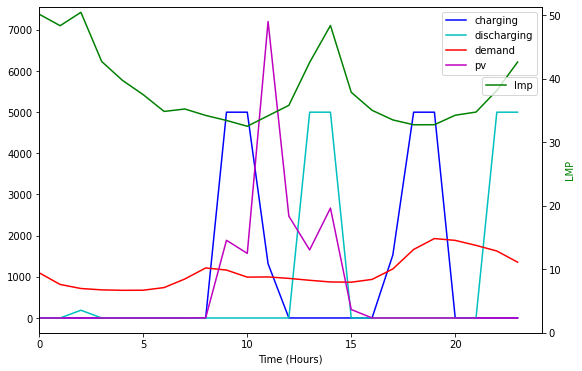

In [15]:
t = np.arange(n)
# demand given in kWh
p_dem_big = p_dem * 10 ** 3

fig,ax = plt.subplots(figsize=(9,6))
ax.plot(t, p_cha.value, 'b', label='charging')
ax.plot(t, p_dis.value, 'c', label='discharging')
ax.plot(t, p_dem_big, 'r', label='demand')
ax.plot(t, p_pv, 'm', label='pv')
plt.legend()
ax.set_xlabel('Time (Hours)')
ax2=ax.twinx()
ax2.plot(t, _lmp, 'g', label='lmp')
ax2.set_ylabel('LMP', color='g')
plt.legend(loc='upper right', bbox_to_anchor=(1., 0.8))
plt.axis((0, None, 0, None))
plt.show()


In [16]:
# Manually see some of the data shown in the graph above
print("Charging                   Discharging              Demand                   LMP")
for i in range(n):
    print(p_cha.value[i], "    ", p_dis.value[i], "    ", p_dem[i], "    ", _lmp[i])

Charging                   Discharging              Demand                   LMP
1.117998729557896e-07      1.2560064667479196e-06      1.0954725932611      50.17707
1.5559055947054432e-07      2.269628318665863e-07      0.81428284432384      48.37496
8.442636404992523e-08      187.99999872267557      0.716287112922707      50.48109
2.346477466658046e-07      1.5582493198887078e-07      0.682698254822347      42.73274
2.6125255658752296e-07      1.634731706420985e-07      0.672265810711454      39.75889
3.1307600318418303e-07      1.6021835090425956e-07      0.67463152975952      37.50306
1.9099144290187104e-06      1.1492029601710535e-07      0.738510914923556      34.87104
5.818173451223744e-07      1.3521274616887564e-07      0.948090636243138      35.25316
1.5497018000173354e-05      1.1070371569753318e-07      1.21520920219497      34.23951
4999.999999255779      9.371345943536129e-08      1.16430655791825      33.45005
4999.999999686445      7.858393528387891e-08      0.992004361